# Schechter Luminosity Function → VID Forecast Demo

This notebook builds the single-source intensity distribution $p_1(I)$ from a Schechter (or double-power-law) luminosity function and constructs the voxel intensity distribution (VID) for line intensity mapping forecasts.

Features:
- Uses **Astropy cosmology** for distances and voxel volume.
- Adjustable LF parameters, voxel size, and redshift.
- Produces $p_1(I)$ and VID plots.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u


In [3]:
# -----------------------------
# Survey / voxel parameters
# -----------------------------
z = 6.0                     # redshift
nu_rest = 1900.54e9          # Hz (CII 158 micron)
Delta_theta = 1.0            # voxel angular size [deg]
Delta_v = 50.0               # voxel spectral width [km/s]

# Convert to SI/CGS
D_L = cosmo.luminosity_distance(z).to(u.cm).value
Delta_Omega = (Delta_theta*np.pi/180.0)**2   # sr (square voxel approx)
nu_obs = nu_rest/(1+z)
Delta_nu = nu_obs * (Delta_v*1e3/3e8)        # Hz

# Conversion constant
C = 4*np.pi*D_L**2 * (1+z) * Delta_Omega * Delta_nu
print("C =", C)


C = 4.015481820088672e+64


In [4]:
# -----------------------------
# Schechter LF parameters (toy)
# -----------------------------
phi_star = 1e-3   # Mpc^-3
L_star   = 1e9    # Lsun
alpha    = -1.2

Lsun = 3.828e33   # erg/s
L_star_cgs = L_star * Lsun

def phi_L(L):
    """Schechter LF in [Mpc^-3 / (erg/s)]."""
    return (phi_star/L_star_cgs) * (L/L_star_cgs)**alpha * np.exp(-L/L_star_cgs)

# Normalization
L_min, L_max = 1e6*Lsun, 1e12*Lsun
L_grid = np.logspace(np.log10(L_min), np.log10(L_max), 2000)
n_bar = np.trapz(phi_L(L_grid), L_grid)
print("Mean source density n_bar =", n_bar, "Mpc^-3")


Mean source density n_bar = 0.01408934802802663 Mpc^-3


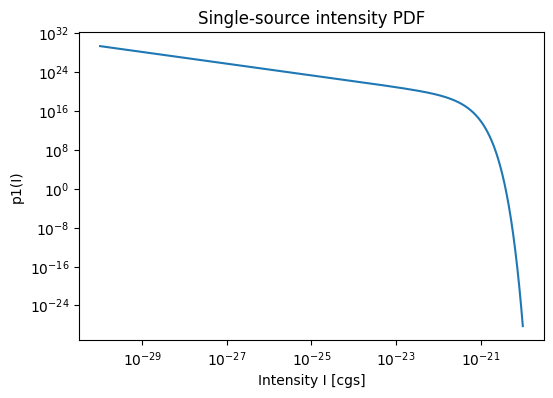

In [5]:
# -----------------------------
# Build p1(I)
# -----------------------------
I_grid = np.logspace(-30, -20, 2000)  # erg s^-1 cm^-2 sr^-1 Hz^-1
L_of_I = C*I_grid
p1 = (C/n_bar) * phi_L(L_of_I)
p1 /= np.trapz(p1, I_grid)  # normalize

plt.figure(figsize=(6,4))
plt.loglog(I_grid, p1)
plt.xlabel("Intensity I [cgs]")
plt.ylabel("p1(I)")
plt.title("Single-source intensity PDF")
plt.show()


Voxel volume [Mpc^3] = 3.327580441393675e+20
Mean count per voxel = 4.688343893004996e+18


C:\Users\juzz\AppData\Local\Temp\ipykernel_17552\2266755621.py:16: RuntimeWarning: overflow encountered in exp
  P_k = np.exp(lambda_vox*(phi_k - 1))


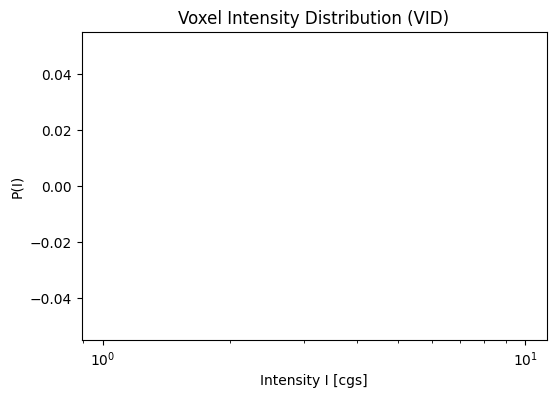

In [6]:
# -----------------------------
# Voxel volume and Poisson VID
# -----------------------------
chi = cosmo.comoving_distance(z).to(u.Mpc).value
H_z = cosmo.H(z).to(u.s**-1).value
dchi_dz = 3e5/H_z / 1e3  # Mpc per unit z
Delta_chi = dchi_dz * (Delta_nu/nu_obs) * (1+z)  # Mpc

V_vox = chi**2 * Delta_Omega * Delta_chi  # Mpc^3
lambda_vox = n_bar * V_vox
print("Voxel volume [Mpc^3] =", V_vox)
print("Mean count per voxel =", lambda_vox)

# Fourier method
phi_k = np.fft.fft(p1)
P_k = np.exp(lambda_vox*(phi_k - 1))
P_I = np.real(np.fft.ifft(P_k))
P_I = np.maximum(P_I,0)
P_I /= np.trapz(P_I, I_grid)

plt.figure(figsize=(6,4))
plt.semilogx(I_grid, P_I)
plt.xlabel("Intensity I [cgs]")
plt.ylabel("P(I)")
plt.title("Voxel Intensity Distribution (VID)")
plt.show()
